In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any

import sys
import os

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from gratis_precip.features import (
    # Base features
    LengthFeature,
    NPeriodsFeature,
    PeriodsFeature,
    NDiffsFeature,
    NSDiffsFeature,
    ACFFeature,
    PACFFeature,
    EntropyFeature,
    NonlinearityFeature,
    HurstFeature,
    StabilityFeature,
    LumpinessFeature,
    UnitRootFeature,
    HeterogeneityFeature,
    TrendFeature,
    SeasonalStrengthFeature,
    SpikeFeature,
    LinearityFeature,
    CurvatureFeature,
    RemainderACFFeature,
    ARCHACFFeature,
    GARCHACFFeature,
    ARCHR2Feature,
    GARCHR2Feature,
    # Precipitation-specific features
    TotalPrecipitation,
    PrecipitationIntensity,
    DrySpellDuration,
    WetSpellDuration,
    PrecipitationVariability,
    ExtremePrecipitationFrequency,
    MaximumDailyPrecipitation,
    WetDayFrequency,
)
from gratis_precip.dimensionality_reduction import (
    DimensionalityReducer,
    TSNEReduction,
    PCAReduction,
)

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [2]:
# Load the precipitation data
df = pd.read_csv("/Users/cooper/Desktop/gratis-precip/data/GSTEIGmeteo copy.csv")
precipitation = df["P_mix"].values


In [3]:
def split_into_seasons(
    precipitation: np.ndarray, days_per_season: int = 90
) -> Tuple[List[np.ndarray], List[str]]:
    """
    Split a long precipitation time series into seasonal segments.

    Args:
        precipitation (np.ndarray): The full precipitation time series.
        days_per_season (int): Number of days to consider for each season.

    Returns:
        Tuple[List[np.ndarray], List[str]]: List of seasonal segments and their corresponding season labels.
    """
    segments = []
    labels = []
    seasons = ["Winter", "Spring", "Summer", "Autumn"]

    for i in range(0, len(precipitation) - days_per_season + 1, days_per_season):
        segment = precipitation[i : i + days_per_season]
        segments.append(segment)
        labels.append(seasons[(i // days_per_season) % 4])

    return segments, labels


def classify_seasons(segments: List[np.ndarray], labels: List[str]) -> List[str]:
    """
    Classify seasons as 'Dry' or 'Wet' based on total precipitation.

    Args:
        segments (List[np.ndarray]): List of seasonal precipitation segments.
        labels (List[str]): List of corresponding season labels.

    Returns:
        List[str]: List of classified season labels.
    """
    totals = [np.sum(segment) for segment in segments]
    median = np.median(totals)

    classified_labels = []
    for total, label in zip(totals, labels):
        if total < median:
            classified_labels.append(f"Dry {label}")
        else:
            classified_labels.append(f"Wet {label}")

    return classified_labels

In [4]:
# Split the precipitation data into seasonal segments
segments, season_labels = split_into_seasons(precipitation)

# Classify the seasons
classified_labels = classify_seasons(segments, season_labels)

In [5]:
def flatten(item):
    """Recursively flatten an arbitrarily nested iterable."""
    if isinstance(item, (list, tuple, np.ndarray)):
        return [sub_item for i in item for sub_item in flatten(i)]
    else:
        return [item]


class FeatureExtractor:
    def __init__(self, features: List[Any]):
        self.features = features

    def extract_features(self, time_series: np.ndarray) -> Dict[str, Any]:
        return {
            feature.__class__.__name__: feature.calculate(time_series)
            for feature in self.features
        }

    def extract_feature_matrix(self, time_series_list: List[np.ndarray]) -> np.ndarray:
        all_feature_vectors = []

        for ts in time_series_list:
            features = self.extract_features(ts)
            feature_vector = []
            for value in features.values():
                feature_vector.extend(flatten(value))
            all_feature_vectors.append(feature_vector)

        # Find the maximum length of feature vectors
        max_length = max(len(vector) for vector in all_feature_vectors)

        # Pad shorter vectors with zeros
        uniform_feature_vectors = [
            vector + [0] * (max_length - len(vector)) for vector in all_feature_vectors
        ]

        return np.array(uniform_feature_vectors)

In [6]:
extractor = FeatureExtractor(
    [
        # Base features
        LengthFeature(),
        NPeriodsFeature(),
        PeriodsFeature(),
        NDiffsFeature(),
        NSDiffsFeature(),
        ACFFeature(),
        PACFFeature(),
        EntropyFeature(),
        NonlinearityFeature(),
        HurstFeature(),
        StabilityFeature(),
        LumpinessFeature(),
        UnitRootFeature(),
        HeterogeneityFeature(),
        TrendFeature(),
        SeasonalStrengthFeature(),
        SpikeFeature(),
        LinearityFeature(),
        CurvatureFeature(),
        RemainderACFFeature(),
        ARCHACFFeature(),
        GARCHACFFeature(),
        ARCHR2Feature(),
        GARCHR2Feature(),
        # Precipitation-specific features
        TotalPrecipitation(),
        PrecipitationIntensity(),
        DrySpellDuration(),
        WetSpellDuration(),
        PrecipitationVariability(),
        ExtremePrecipitationFrequency(),
        MaximumDailyPrecipitation(),
        WetDayFrequency(),
    ]
)


In [7]:
# Extract features for all segments
feature_matrix = extractor.extract_feature_matrix(segments)
print(f"Feature matrix shape: {feature_matrix.shape}")

Feature matrix shape: (59, 42)


In [8]:
# Perform dimensionality reduction
reducer = DimensionalityReducer(PCAReduction())
projection = reducer.reduce_dimensions(feature_matrix)

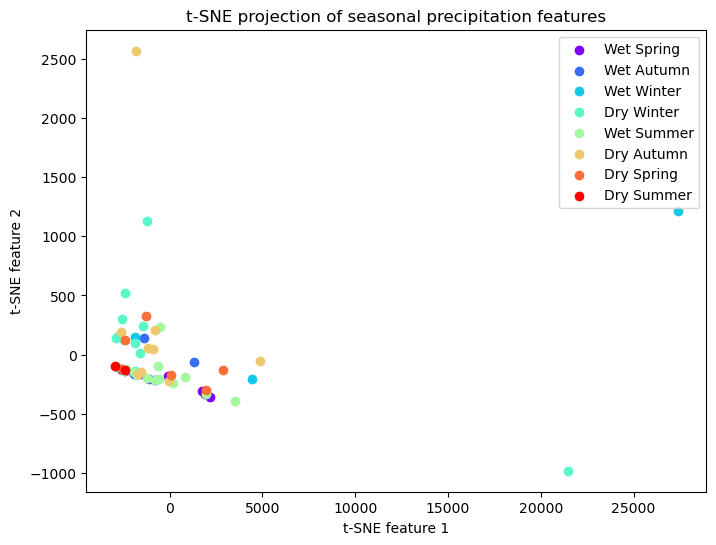

In [9]:
# Visualize the projection
plt.figure(figsize=(8, 6))

unique_labels = list(set(classified_labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = np.array(classified_labels) == label
    plt.scatter(projection[mask, 0], projection[mask, 1], label=label, color=color)

plt.title("t-SNE projection of seasonal precipitation features")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend()
plt.show()

In [10]:
# Print some statistics
for season in set(classified_labels):
    season_data = [
        seg for seg, label in zip(segments, classified_labels) if label == season
    ]
    print(f"\n{season} statistics:")
    print(
        f"  Average daily precipitation: {np.mean([np.mean(seg) for seg in season_data]):.2f}"
    )
    print(
        f"  Total seasonal precipitation: {np.mean([np.sum(seg) for seg in season_data]):.2f}"
    )
    print(
        f"  Maximum daily precipitation: {np.max([np.max(seg) for seg in season_data]):.2f}"
    )


Wet Spring statistics:
  Average daily precipitation: 4.82
  Total seasonal precipitation: 433.88
  Maximum daily precipitation: 52.50

Wet Autumn statistics:
  Average daily precipitation: 4.50
  Total seasonal precipitation: 405.08
  Maximum daily precipitation: 50.60

Wet Winter statistics:
  Average daily precipitation: 4.28
  Total seasonal precipitation: 384.80
  Maximum daily precipitation: 73.00

Dry Winter statistics:
  Average daily precipitation: 2.95
  Total seasonal precipitation: 265.73
  Maximum daily precipitation: 68.10

Wet Summer statistics:
  Average daily precipitation: 4.87
  Total seasonal precipitation: 437.85
  Maximum daily precipitation: 53.80

Dry Autumn statistics:
  Average daily precipitation: 3.14
  Total seasonal precipitation: 282.18
  Maximum daily precipitation: 57.60

Dry Spring statistics:
  Average daily precipitation: 3.03
  Total seasonal precipitation: 272.27
  Maximum daily precipitation: 50.20

Dry Summer statistics:
  Average daily precipit

In [11]:
from gratis_precip.models import ARMAComponent, CompositeComponent, MARDataGenerator
from gratis_precip.utils.plotting import plot_multiple_time_series
import matplotlib.pyplot as plt

In [12]:
# # Load the precipitation data
# df = pd.read_csv("/Users/cooper/Desktop/gratis-precip/data/GSTEIGmeteo copy.csv")
# df.index = pd.to_datetime(df["date"])
# data = df["P_mix"]

In [13]:
from datetime import datetime
from meteostat import Point, Daily

# Define the location (latitude, longitude, and altitude)
location = Point(47.368011576362896, 8.5387625442684280)  # Example: Zurich

# Define the time period
start = datetime(1986, 1, 1)
end = datetime(2023, 12, 31)

# Get daily data
data = Daily(location, start, end)
data = data.fetch()

# Print precipitation data
print(data[['prcp']])

data = data['prcp']


            prcp
time            
1986-01-01   4.0
1986-01-02   1.7
1986-01-03   4.9
1986-01-04   0.4
1986-01-05   1.2
...          ...
2023-12-27   0.0
2023-12-28   0.4
2023-12-29   0.1
2023-12-30   0.0
2023-12-31   2.4

[13879 rows x 1 columns]


In [14]:
# Create ARMA components
arma1 = ARMAComponent(order=(2, 3), weight=1)
arma2 = ARMAComponent(order=(1, 2), weight=1)
arma3 = ARMAComponent(order=(0, 1), weight=1)


# Create composite component (mixture of ARMA models)
composite = CompositeComponent([arma1, arma2])

# Create MARDataGenerator
mar_generator = MARDataGenerator(components=composite, steps=len(data))

# Fit the model to your data
mar_generator.fit(data)

# Generate synthetic data
generated_data = mar_generator.generate(n_trajectories=5)

2024-07-10 00:05:19,922 - INFO - Generating 5 trajectories...
2024-07-10 00:05:20,001 - INFO - Final generated trajectories:
2024-07-10 00:05:20,007 - INFO -               Sim_1         Sim_2         Sim_3         Sim_4         Sim_5
count  13283.000000  13272.000000  13221.000000  13252.000000  13225.000000
mean       1.851746      1.825672      1.930639      1.834033      1.965220
std        3.150357      3.031815      7.604581      4.103799      6.203150
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.560298      0.571476      0.548352      0.544870      0.565846
50%        1.179256      1.200481      1.185985      1.182985      1.197588
75%        2.162454      2.133669      2.137848      2.108419      2.187432
max       84.474844    129.046683    733.841028    234.729421    480.011148


In [15]:
generated_data

,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5
time,,,,,
1986-01-01,0.714754,0.651472,14.813325,0.000000,1.405147
1986-01-02,0.541575,0.293113,3.484331,0.176909,1.084272
1986-01-03,1.713225,0.349287,0.000000,4.147545,0.428513
1986-01-04,0.164545,0.815869,0.186826,2.878143,1.649592
1986-01-05,0.000000,0.737624,2.143417,1.755322,0.653224
...,...,...,...,...,...
2023-12-27,2.171301,3.042886,0.863620,1.351343,1.211347
2023-12-28,9.886990,0.076772,2.025500,1.076272,1.026339
2023-12-29,1.900996,1.523040,1.167213,1.655141,0.520664


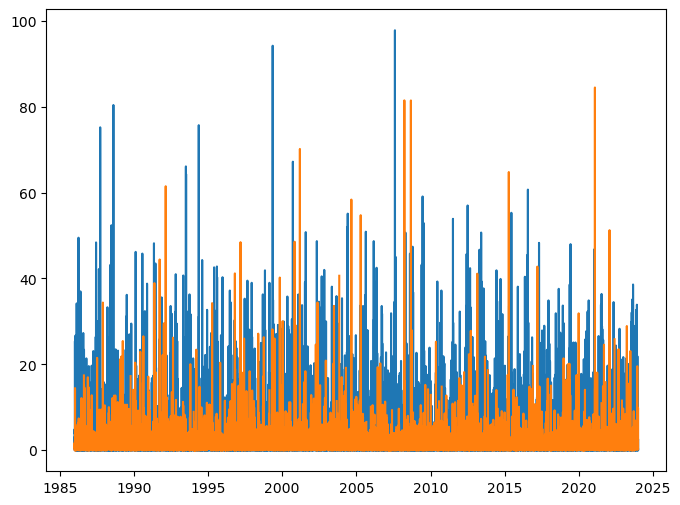

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(data)
plt.plot(generated_data['Sim_1'])


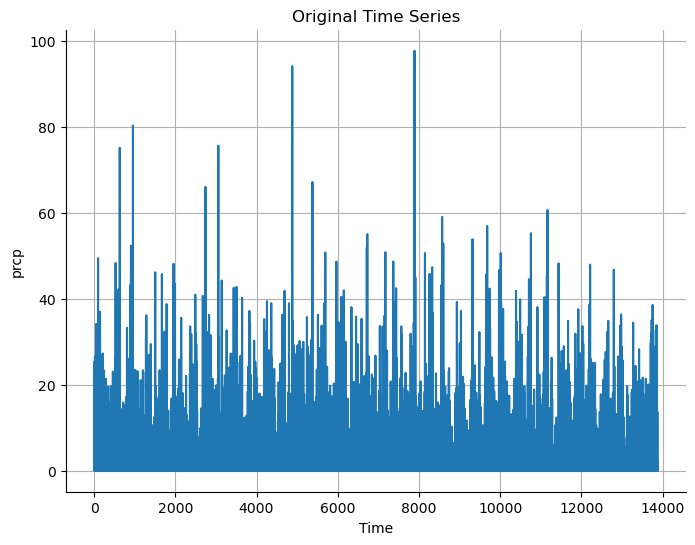

2024-07-10 00:05:20,250 - INFO - Generating 1 trajectories...
2024-07-10 00:05:20,266 - INFO - Final generated trajectories:
2024-07-10 00:05:20,269 - INFO -               Sim_1
count  13234.000000
mean       1.836088
std        2.909063
min        0.000000
25%        0.577955
50%        1.223139
75%        2.192825
max       91.615371


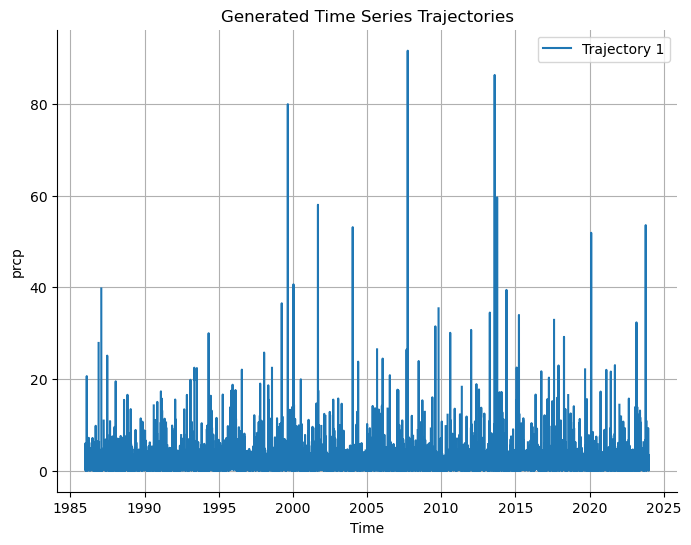

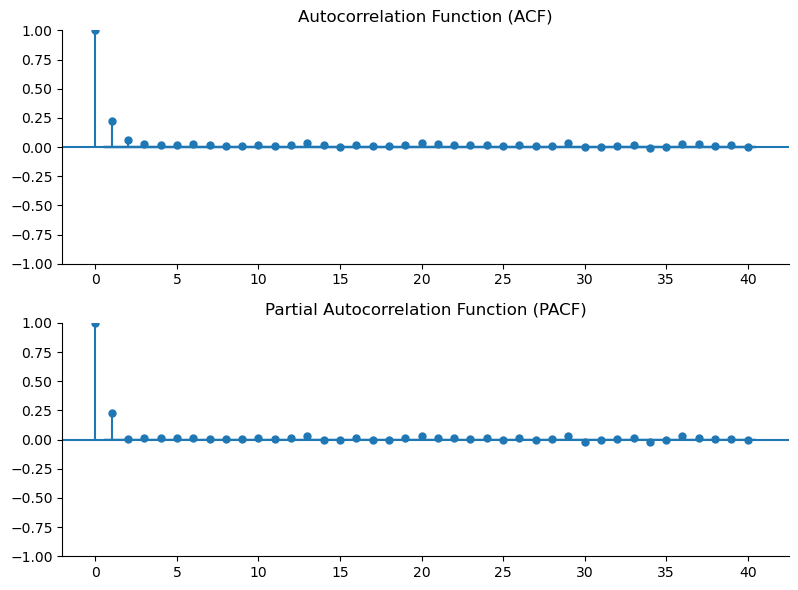

In [17]:
# Plot results
mar_generator.plot_original_data()
mar_generator.plot_generated_trajectories(n_trajectories=1)
mar_generator.display_acf_pacf_plots()